In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

## XYZ -> RGB matrix inference

In [2]:
m709 = np.mat([[0.64, 0.33, 0.03],
                [0.3, 0.6, 0.1],
                [0.15, 0.06, 0.79]])

xr, yr, zr = np.squeeze(np.array(m709[0]))
xg, yg, zg = np.squeeze(np.array(m709[1]))
xb, yb, zb = np.squeeze(np.array(m709[2]))
xw, yw, zw = 0.3127, 0.3291, 0.3582

#xyz -> rgb matrix, before scaling to white.
rx, ry, rz = (yg * zb) - (yb * zg), (xb * zg) - (xg * zb), (xg * yb) - (xb * yg)
gx, gy, gz = (yb * zr) - (yr * zb), (xr * zb) - (xb * zr), (xb * yr) - (xr * yb)
bx, by, bz = (yr * zg) - (yg * zr), (xg * zr) - (xr * zg), (xr * yg) - (xg * yr)

#White scaling factors.
#Dividing by yw scales the white luminance to unity, as conventional.
rw = ((rx * xw) + (ry * yw) + (rz * zw)) / yw
gw = ((gx * xw) + (gy * yw) + (gz * zw)) / yw
bw = ((bx * xw) + (by * yw) + (bz * zw)) / yw

#xyz -> rgb matrix, correctly scaled to white.
rx = rx / rw;  ry = ry / rw;  rz = rz / rw;
gx = gx / gw;  gy = gy / gw;  gz = gz / gw;
bx = bx / bw;  by = by / bw;  bz = bz / bw;

test_mat = np.mat([[rx, ry, rz],
                    [gx, gy, gz],
                    [bx, by, bz]])

print (test_mat)

[[ 3.24297897 -1.53833618 -0.49891984]
 [-0.96899795  1.87549198  0.04154452]
 [ 0.05566832 -0.20411719  1.05769816]]


## Simple Analytic Approximations to the CIE XYZ Color Matching Functions
by Chris Wyman, Peter-Pike Sloan Peter Shirley

In [3]:
def ts(wl, alpha, beta, gamma, delta):
    c = wl - beta
    return alpha * np.exp(-0.5 * (c * (gamma if (c < 0) else delta))**2)

def fit(wl, *args):
    return np.sum([ts(wl, *coeffs) for coeffs in args])

def wl_2_xyz(wl):
    x_coeffs = ((0.362, 442.0, 0.0624, 0.0374),
                (1.056, 599.8, 0.0264, 0.0323),
                (-0.065, 501.1, 0.0490, 0.0382))

    y_coeffs = ((0.821, 568.8, 0.0213, 0.0247),
                (0.286, 530.9, 0.0613, 0.0322))

    z_coeffs = ((1.217, 437.0, 0.0845, 0.0278),
                (0.681, 459.0, 0.0385, 0.0725))

    return np.mat([fit(wl, *x_coeffs), fit(wl, *y_coeffs), fit(wl, *z_coeffs)])

def xyz_2_chr(xyz):
    """XYZ to chromaticity coordinates"""
    x,y,z = (c/sum(xyz) for c in xyz)
    return x,y,z

## Wavelength -> RGB conversion

In [4]:
RGB_M = np.mat([[1.7552599, -0.4836786, -0.2530000],
                [-0.5441336,  1.5068789,  0.0215528],
                [0.0063467, -0.0175761,  1.2256959]])


sRGB_M = np.mat([[3.2404542, -1.5371385, -0.4985314],
                 [-0.9692660,  1.8760108,  0.0415560],
                 [0.0556434, -0.2040259,  1.0572252]])

ACES = np.mat([[1.0498110175, 0.0, -0.0000974845],
              [-0.4959030231, 1.3733130458, 0.0982400361],
              [0.0, 0.0, 0.9912520182]])


def stretch01(rgb):
    top = np.max(rgb)
    bottom = np.min(rgb)
    rang = top - bottom
    return (rgb - bottom)/rang

White is [ 0.68522342  0.29870292  0.42072795]


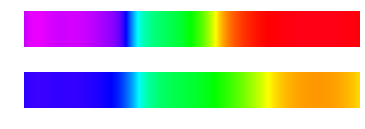

In [5]:
def wl_2_rgb(wl, M = sRGB_M):
    tmp = wl_2_xyz(wl) * M
    tmp = np.squeeze(np.array(tmp))
    return stretch01(tmp)

spectre = np.arange(400, 680, 1)

fig = plt.figure()

spec1 = np.array([wl_2_rgb(wl) for wl in spectre])
spec1_w = np.mean(spec1, 0)
clr1 = np.repeat(np.array([spec1]), 30, axis=0)

spec2= np.array([wl_2_rgb(wl, M = ACES) for wl in spectre])
clr2 = np.repeat(np.array([spec2]), 30, axis=0)

img1 = fig.add_subplot(111)
img1.set_axis_off()
t1 = img1.imshow(clr1)

img2 = fig.add_subplot(212)
img2.set_axis_off()
t2 = img2.imshow(clr2)

print ("White is", spec1_w)

D65 white [ 0.65270409  0.32097981  0.44882266]


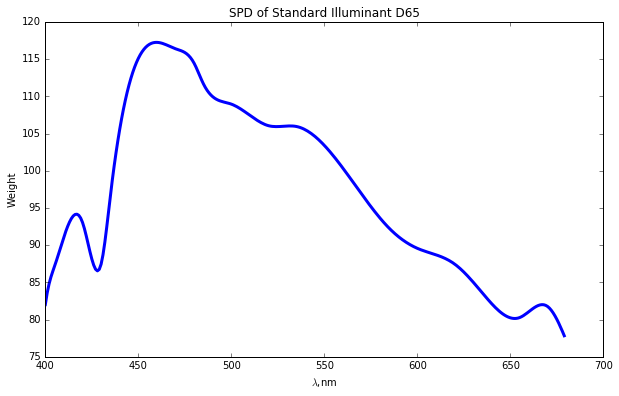

In [6]:
cie_d65_data = np.genfromtxt("CIE_D65.csv", skip_header=5)

# wavelength and weights
wvls = cie_d65_data.T[0]
weigths = cie_d65_data.T[1]


from scipy.interpolate import UnivariateSpline

spl = UnivariateSpline(wvls, weigths)

figd65 = plt.figure(figsize=(10, 6))
ax = figd65.add_subplot(111, title="SPD of Standard Illuminant D65", ylabel="Weight", xlabel="$\lambda$,nm")
pl = ax.plot(spectre, spl(spectre), "b", lw=3)

spec1_wd65 = np.average(spec1, 0, spl(spectre))
print ("D65 white", spec1_wd65)